<a href="https://colab.research.google.com/github/Heibattttt/A5MOVIE/blob/main/Copy_of_HM4_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/


mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [1]:
 #!/bin/bash
!kaggle datasets download grouplens/movielens-20m-dataset


Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
 97% 189M/195M [00:01<00:00, 137MB/s]
100% 195M/195M [00:01<00:00, 130MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('movielens-20m-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


## **1. Recommendation System with LSH**



### **1.1 Data Preparation**

The following steps are data preparation, to ensure that our dataset is clean and structured in a way that makes it ready for building recommendation system or performing any other analysis.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [4]:
rating = pd.read_csv('data/rating.csv')
movie = pd.read_csv('data/movie.csv')

In [5]:
print(rating.head())
print(movie.head())

   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [6]:
print(rating.info())  # Get info on null values and data types
print(movie.info())   # Same for movies dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None


In [7]:
print(rating.describe())  # Get statistical details about ratings
print(movie['genres'].value_counts())

             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00
genres
Drama                                                  4520
Comedy                                                 2294
Documentary                                            1942
Comedy|Drama                                           1264
Drama|Romance                                          1075
                                                       ... 
Action|Comedy|Crime|Western                               1
Action|Fantasy|Sci-Fi|Thriller                            1
Action|Drama|Fantasy|Horror|Mystery|Sci-Fi|Thriller       1
Action|Drama|Fantasy|

In [16]:
rating['timestamp'] = pd.to_datetime(rating['timestamp']) #to ensure a correct format for timestamps


In [17]:
# Merging the rating data with the movie data
movie_rating = pd.merge(rating, movie, on='movieId')

# Clean up genres
movie_rating['clean_genres'] = movie_rating['genres'].str.replace('|', ' ', regex=False)

print(movie_rating[['clean_genres']].head())


                             clean_genres
0              Adventure Children Fantasy
1  Adventure Drama Fantasy Mystery Sci-Fi
2                 Mystery Sci-Fi Thriller
3                        Mystery Thriller
4                  Crime Mystery Thriller


In [18]:
movie_rating = pd.merge(rating, movie, on='movieId', how='inner')

movie_rating.head()

,userId,movieId,rating,timestamp,title,genres,clean_genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,Adventure Drama Fantasy Mystery Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,Mystery Sci-Fi Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Mystery Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,Crime Mystery Thriller


In [19]:
n_ratings = len(rating)
n_movies = len(rating['movieId'].unique())
n_users = len(rating['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 20000263
Number of unique movieId's: 26744
Number of unique users: 138493
Average ratings per user: 144.41
Average ratings per movie: 747.84


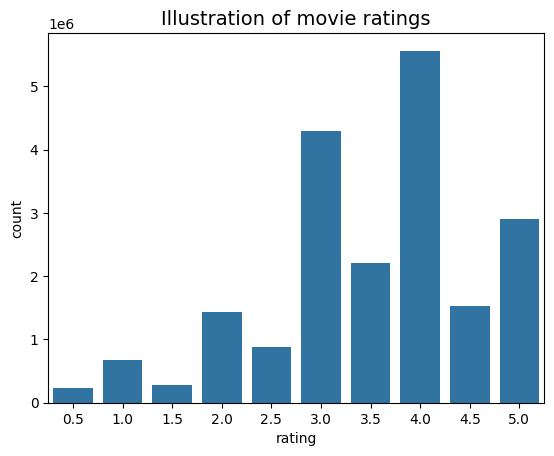

In [13]:
sns.countplot(x='rating', data=rating)
plt.title("Illustration of movie ratings", fontsize=14)
plt.show()

In [21]:
# general rating behavior of the users in the dataset
print(f"Mean rating: {round(rating['rating'].mean(), 2)}")
mean_rating = rating.groupby('movieId')[['rating']].mean()
print(f"Mean rating per user: {round(mean_rating['rating'].mean(), 2)}")

Mean rating: 3.53
Mean rating per user: 3.13


In [20]:
#number of rating times for each MovieId
rating['movieId'].value_counts()


,count
movieId,
296,67310
356,66172
318,63366
593,63299
480,59715
...,...
125545,1
78873,1
112907,1


In [ ]:
#The 10 Most rated movies.
movie_rating = rating.merge(movie, on='movieId')
movie_rating['title'].value_counts()[0:10]

In [34]:
#The lowest rated movie.
mean_rating = rating.groupby('movieId')[['rating']].mean()
lowest_rated = mean_rating['rating'].idxmin()
movie.loc[movie['movieId'] == lowest_rated]

,movieId,title,genres,clean_genres
8176,8859,SuperBabies: Baby Geniuses 2 (2004),Comedy,Comedy


In [33]:
#The highest rated movie.
mean_rating = rating.groupby('movieId')[['rating']].mean()
highest_rated = mean_rating['rating'].idxmax()
movie.loc[movie['movieId'] == highest_rated]

,movieId,title,genres,clean_genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama,Crime Drama


# **1.2 Minhash Signatures**

### **> MinHash function**

In [ ]:
import pandas as pd
import numpy as np
import random

class MinHashRecommender:
    def __init__(self, num_hashes=100):
        """
        Initialize MinHash recommender with configurable hash functions

        Args:
            num_hashes (int): Number of hash functions to use
        """
        self.num_hashes = num_hashes
        self.hash_functions = None
        self.user_signatures = None

    def generate_hash_functions(self, max_value):
        """
        Generate universal hash functions

        Args:
            max_value (int): Maximum value to use in hash function generation
        """
        # Use cryptographically secure prime
        prime = 2**61 - 1  # Mersenne prime

        self.hash_functions = []
        for _ in range(self.num_hashes):
            # More robust hash function generation
            a = random.randint(1, prime - 1)
            b = random.randint(0, prime - 1)
            self.hash_functions.append((a, b, prime))
    def compute_signatures(self, user_sets):
        """
        Compute MinHash signatures for user sets

        Args:
            user_sets (dict): Dictionary of user IDs to sets of items

        Returns:
            dict: MinHash signatures for each user
        """
        if not self.hash_functions:
            raise ValueError("Hash functions not generated. Call generate_hash_functions first.")

        signatures = {}
        for user_id, item_set in user_sets.items():
            user_signature = []
            for a, b, prime in self.hash_functions:
                # Compute minimum hash for the set
                min_hash = min((a * item + b) % prime for item in item_set)
                user_signature.append(min_hash)
            signatures[user_id] = user_signature

        self.user_signatures = signatures
        return signatures

    def compute_similarity(self, signature1, signature2):
        """
        Estimate Jaccard similarity using MinHash signatures

        Args:
            signature1 (list): MinHash signature for first set
            signature2 (list): MinHash signature for second set

        Returns:
            float: Estimated Jaccard similarity
        """
        # Count matching hash values
        matches = sum(s1 == s2 for s1, s2 in zip(signature1, signature2))
        return matches / len(signature1)

    def get_most_similar_users(self, target_user, top_k=5):
        """
        Find most similar users to a target user

        Args:
            target_user (int): User ID to find similar users for
            top_k (int): Number of similar users to return

        Returns:
            list: Top K most similar users
        """
        if not self.user_signatures:
            raise ValueError("Signatures not computed. Call compute_signatures first.")

        similarities = []
        target_signature = self.user_signatures[target_user]

        for user_id, signature in self.user_signatures.items():
            if user_id != target_user:
                similarity = self.compute_similarity(target_signature, signature)
                similarities.append((user_id, similarity))

        # Sort and return top K similar users
        return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]



def main():

    # Load rating data
    rating = pd.read_csv('data/rating.csv')

    # Convert to user-movie sets
    user_movies = rating.groupby('userId')['movieId'].apply(set).to_dict()

    # Initialize and run MinHash
    recommender = MinHashRecommender(num_hashes=100)
    recommender.generate_hash_functions(max(rating['movieId']))
    recommender.compute_signatures(user_movies)

    # Find most similar users to user 1
    similar_users = recommender.get_most_similar_users(1)
    print("Most similar users to user 1:")
    for user, similarity in similar_users:
        print(f"User {user}: Similarity = {similarity:.4f}")

if __name__ == "__main__":
    main()

Most similar users to user 1:
User 111424: Similarity = 0.3300
User 24743: Similarity = 0.3100
User 50738: Similarity = 0.3000
User 57492: Similarity = 0.3000
User 25286: Similarity = 0.2900


## **1.3 Locality-Sensitive Hashing (LSH)**


In [ ]:
import numpy as np
import hashlib
from collections import defaultdict
import pandas as pd
import random

# 1. Bucket Creation
# Number of bands and hash functions per band
num_bands = 20  # You can adjust this number
num_hashes = 100  # Number of hash functions used in the MinHash

# Helper function to split the signature into bands
def split_into_bands(signature, num_bands, num_hashes):
    band_size = num_hashes // num_bands
    bands = []

    # Split the signature into bands (each band of size `band_size`)
    for i in range(num_bands):
        band = tuple(signature[i * band_size:(i + 1) * band_size])
        bands.append(band)

    return bands

# Load rating data to generate user signatures
rating = pd.read_csv('data/rating.csv')
user_movies = rating.groupby('userId')['movieId'].apply(set).to_dict()

recommender = MinHashRecommender(num_hashes=num_hashes)
recommender.generate_hash_functions(max(rating['movieId']))
user_signatures = recommender.compute_signatures(user_movies) # define of user_signatures

#  Apply banding to one user's signature
user_id = 1
signature = user_signatures[user_id]  # Get the MinHash signature of user 1
bands = split_into_bands(signature, num_bands, num_hashes)

# Check the bands for this user
print(f"Bands for user {user_id}: {bands}")


# Hash function to hash a band
def hash_band(band):

    return hashlib.md5(str(band).encode('utf8')).hexdigest()

# Hash each band and place users in buckets
def create_buckets(user_signatures, num_bands, num_hashes):
    buckets = defaultdict(list)

    for user_id, signature in user_signatures.items():
        # Split the signature into bands
        bands = split_into_bands(signature, num_bands, num_hashes)

        # For each band, hash it and put the user into the corresponding bucket
        for i, band in enumerate(bands):
            band_hash = hash_band(band)
            buckets[band_hash].append(user_id)

    return buckets

# Create the buckets for all users
buckets = create_buckets(user_signatures, num_bands, num_hashes)

# Debugging Tip: Check a few bucket contents to verify users are grouped together
for bucket_id, users in list(buckets.items())[:5]:  # Check the first 5 buckets
    print(f"Bucket {bucket_id}: {users}")

# 2. Query function to find similar users for a given user

def find_similar_users(query_user_id, user_signatures, buckets, num_bands, num_hashes):
    # Get the MinHash signature for the query user
    query_signature = user_signatures[query_user_id]

    # Split the query user's signature into bands
    query_bands = split_into_bands(query_signature, num_bands, num_hashes)

    similar_users = set()

    # For each band, check the bucket and find users in the same bucket
    for band in query_bands:
        band_hash = hash_band(band)

        # If the band hash exists in the buckets, add the users to the similar_users set
        if band_hash in buckets:
            similar_users.update(buckets[band_hash])

    # Remove the query user from the similar users (since a user is most similar to themselves)
    similar_users.discard(query_user_id)

    return similar_users

#  Find similar users for user 1
query_user_id = 1
similar_users = find_similar_users(query_user_id, user_signatures, buckets, num_bands, num_hashes)

print(f"Similar users for user {query_user_id}: {similar_users}")

Bands for user 1: [(14181551109458200, 31039877338350443, 2464703022543416, 7647005691587380, 27892990264280973), (22952720239950226, 32503900523582403, 763381824832938, 20563023754421543, 26880640332219713), (9583984462463162, 1177341711415372, 2036029014646939, 13197641508338912, 17481650353874788), (12437515927798519, 5645853259296632, 4894517748699169, 17816921118971637, 32321870890337323), (4569445665532279, 1552336475376420, 24428883904857349, 15149581971220501, 30436360730654149), (3910197154223974, 31003814498526347, 1607976081832894, 4107690435138149, 16242250543236628), (6828078483413869, 13198202317405938, 3748705130162140, 5418164958136678, 10385506631625919), (21304319297497444, 6136775103316262, 2850487705742293, 21807130223392052, 4861844182569462), (8681547434835047, 457897353558040, 3722925210617026, 316722379916926, 13609263682446734), (12620524181816837, 5040778687807550, 4761823791760296, 19364429808134402, 6117512137502969), (6960271322914058, 8717150284890900, 432

In [ ]:
import pandas as pd
import numpy as np

# rating DataFrame with user ratings
rating_movie = {
    'userId': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'movieId': ['Inception', 'Titanic', 'Avatar', 'Inception', 'Matrix', 'Toy Story', 'Titanic', 'Avatar', 'Shrek'],
    'rating': [4.5, 4.2, 2.8, 4.6, 3.9, 4.7, 3.8, 4.3, 4.1]
}
rating_df = pd.DataFrame(rating_movie)

# Create a user-item matrix
user_movie_matrix = rating_df.pivot(index='userId', columns='movieId', values='rating')

# Given similar users based on MinHash or LSH (in practice, you would use an actual similarity measure)
user_similarities = {
    1: {2: 0.9, 3: 0.7},  # User 1 is most similar to User 2 (0.9) and User 3 (0.7)
    2: {1: 0.9, 3: 0.6},
    3: {1: 0.7, 2: 0.6}
}

# Function to get the most similar users
def get_similar_users(user_id, user_similarities, top_n=2):
    """Get the top N similar users to a given user."""
    if user_id not in user_similarities:
        return []
    return sorted(user_similarities[user_id].items(), key=lambda x: x[1], reverse=True)[:top_n]

# Function to recommend movies based on common ratings and top-rated movies
def recommend_movies(user_id, user_movie_matrix, user_similarities, top_n_similar_users=2, top_n_recommendations=5):
    # Step 1: Get the most similar users
    similar_users = get_similar_users(user_id, user_similarities, top_n=top_n_similar_users)

    # Extract user IDs of the most similar users
    similar_user_ids = [user for user, _ in similar_users]

    # Step 2: Find common movies rated by both the target user and the similar users
    user_movies = set(user_movie_matrix.loc[user_id].dropna().index)
    common_movies = set(user_movies)

    for sim_user in similar_user_ids:
        sim_user_movies = set(user_movie_matrix.loc[sim_user].dropna().index)
        common_movies.intersection_update(sim_user_movies)

    # Step 3: Calculate the average rating of common movies
    common_movie_ratings = []
    if common_movies:
        for movie in common_movies:
            ratings_for_movie = [user_movie_matrix.loc[sim_user, movie] for sim_user in similar_user_ids]
            avg_rating = np.mean(ratings_for_movie)
            common_movie_ratings.append((movie, avg_rating))

    # Sort common movies by average rating in descending order
    common_movie_ratings.sort(key=lambda x: x[1], reverse=True)

    # Step 4: Create the recommendations list (ensure it's at least 5 items)
    recommendations = []

    # Add common movie recommendations first (sorted by average rating)
    recommendations.extend(common_movie_ratings[:top_n_recommendations])

    # Ensure no duplicate movies (we only want unique movie recommendations)
    recommended_movies_set = set([movie for movie, _ in recommendations])

    # If fewer than 5 recommendations, add top-rated movies from the most similar user
    if len(recommendations) < top_n_recommendations:
        most_similar_user = similar_user_ids[0]
        top_rated_movies = user_movie_matrix.loc[most_similar_user].dropna().sort_values(ascending=False).head(top_n_recommendations - len(recommendations))

        # Add top-rated movies from most similar user, ensuring no duplicates
        for movie, rating in top_rated_movies.items():
            if movie not in recommended_movies_set:  # Ensure no duplicate
                recommendations.append((movie, rating))
                recommended_movies_set.add(movie)  # Add to the set of recommended movies

    # If still fewer than 5, try adding movies from the next most similar user
    if len(recommendations) < top_n_recommendations:
        next_similar_user = similar_user_ids[1] if len(similar_user_ids) > 1 else similar_user_ids[0]
        top_rated_movies = user_movie_matrix.loc[next_similar_user].dropna().sort_values(ascending=False).head(top_n_recommendations - len(recommendations))

        # Add top-rated movies from the second most similar user, ensuring no duplicates
        for movie, rating in top_rated_movies.items():
            if movie not in recommended_movies_set:
                recommendations.append((movie, rating))
                recommended_movies_set.add(movie)

    # 5 recommendations
    return recommendations[:top_n_recommendations]

#Recommend movies for user X
user_id = 'X'
if user_id not in user_movie_matrix.index:
    print(f"User {user_id}")
else:
  recommended_movies = recommend_movies(user_id, user_movie_matrix, user_similarities)

# Display the recommended movies
print(f"Recommended movies for user {user_id}:")
for movie, rating in recommended_movies:
    print(f"Movie: {movie}, Rating: {rating:.1f}")

User X
Recommended movies for user X:
Movie: Toy Story, Rating: 4.7
Movie: Inception, Rating: 4.6
Movie: Matrix, Rating: 3.9
Movie: Avatar, Rating: 4.3
Movie: Shrek, Rating: 4.1
